In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio

import math
import matplotlib.pyplot as plt

import librosa
from librosa.core import stft, istft

from PIL import Image
import IPython.display as ipd

np.random.seed(42)

# Stereo Matching (revisited) 


## 1. im0.ppm (left) and im8.ppm (right) are the pictures taken by two different camera positions1. If you load the images, they will be a three dimensional array of 381 × 430 × 3, whose third dimension is for the three color channels (RGB). Let’s call them XL and XR. For the (i,j)-th pixel in the right image, XR , which is a 3-d vector of RGB intensities, we can scan and (i,j,:) find the most similar pixel in the left image at i-th row (using a metric of your choice). For example, I did the search from XL to XL , to see which pixel among the 40 are (i,j,:) (i,j +39,:) the closest. I record the index-distance of the closest pixel. Let’s say that XL is the (i,j +19,:) most similar one to XR . Then, the index-distance is 19. I record this index-distance (to (i,j,:) the closest pixel in the left image) for all pixels in my right image to create a matrix called “disparity map”, D, whose (i, j)-th element says the index-distance between the (i, j)-th pixel of the right image and its closest pixel in the left image. For an object in the right image, if its pixels are associated with an object in the left image, but are shifted far away, that means the object is close to the camera, and vice versa.

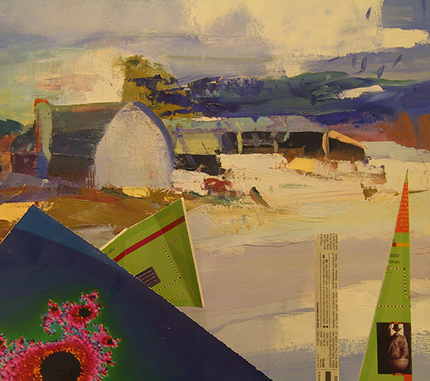

In [2]:
XL = Image.open('data/im0.ppm')
XL

In [3]:
XL = np.array(XL)
XL.shape

(381, 430, 3)

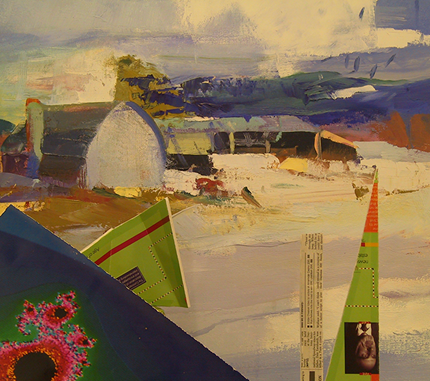

In [4]:
XR = Image.open('data/im8.ppm')
XR

In [5]:
XR = np.array(XR)
print('XR Shape:', XR.shape)

XR Shape: (381, 430, 3)


# 2. Calculate the disparity map D from im0.ppm and im8.ppm, which will be a matrix of 381×390 (since we search within only 40 pixels). Vectorize the disparity matrix and draw a histogram. How many clusters do you see?

In [6]:
D = np.zeros([XL.shape[0], XL.shape[1] - 40])

for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        min_distance = 999999
        for z in range(40):
            index_distance = sum(np.abs(XR[x,y] - XL[x,y+z]))
            if index_distance < min_distance:
                min_distance = index_distance
                D[x,y] = z

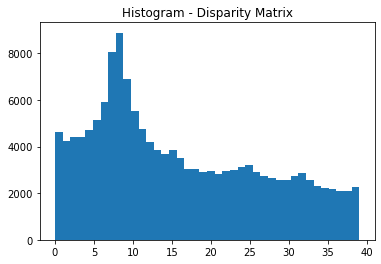

In [7]:
D_vec = D.reshape(-1,1)
D_vec

plt.title('Histogram - Disparity Matrix')
plt.hist(D_vec, bins = 40)
plt.show()

## 3. Write up your own GMM clustering code, and cluster the disparity values in D. Each value will belong to (only) one of the clusters. The number of clusters says the number of depth

In [8]:
k_clusters = 4

prob_k = np.array([1/k_clusters]*k_clusters)

mean_list, SD_list = np.random.uniform(10, 50, k_clusters), np.random.uniform(1, 5, k_clusters)

X, U = np.zeros((np.size(D_vec), k_clusters)), np.zeros((np.size(D_vec), k_clusters))

In [9]:
for _ in range(0,500):
    for i in range(k_clusters):
        
        a = 1/np.sqrt((2*np.pi*(SD_list[i]**2)))
        temp = D_vec - mean_list[i]
        b = np.exp(-(((temp)**2)/(2*(SD_list[i]**2))))
        X[:,i] = (a * b).reshape(1,-1)
        X[X==0] = 0.00005

    prob_X = np.sum(prob_k * X, axis=1)
    prob_X = prob_X.reshape(-1,1)
    U = prob_k * X / prob_X
    prob_k = np.mean(U, axis=0)

    c = np.sum(U*D_vec.reshape(-1,1), axis = 0)
    d = np.sum(U, axis = 0)
    mean_list = c / d

    for i in range(k_clusters):
        temp1 = U[:,i].reshape(-1,1)
        temp2 = D_vec - mean_list[i]
        e = np.sum(temp1 * (temp2 * temp2))
        SD_list[i] = np.sqrt(e / np.sum(U[:,i]))

In [10]:
print("Means: \t\t\t", mean_list)
print("Standard Deviations: \t", SD_list)

Means: 			 [20.32831399 37.90664578 32.53344858  6.61242187]
Standard Deviations: 	 [6.72628084 0.99433516 2.98443146 3.91576546]


In [11]:
df_D = pd.DataFrame(D_vec)
df_D.columns = ['Disparities']
df_D['Cluster Number'] = np.argmax(U, axis = 1)
df_D

,Disparities,Cluster Number
0,5.0,3
1,13.0,3
2,11.0,3
3,7.0,3
4,7.0,3
...,...,...
148585,18.0,0
148586,4.0,3
148587,28.0,0
148588,32.0,2


In [12]:
cluster_arr = np.array(df_D['Cluster Number'])
cluster_arr = cluster_arr.reshape(D.shape)
cluster_arr

array([[3, 3, 3, ..., 0, 0, 3],
       [3, 3, 3, ..., 0, 0, 3],
       [3, 3, 3, ..., 0, 3, 3],
       ...,
       [0, 0, 1, ..., 0, 2, 0],
       [2, 2, 0, ..., 2, 2, 3],
       [0, 2, 0, ..., 0, 2, 2]])

In [13]:
depth_arr = np.array(df_D['Cluster Number'], dtype=float)
for i in range(k_clusters):
    depth_arr[depth_arr == i] = mean_list[i]
depth_arr = depth_arr.reshape(D.shape)
depth_arr

array([[ 6.61242187,  6.61242187,  6.61242187, ..., 20.32831399,
        20.32831399,  6.61242187],
       [ 6.61242187,  6.61242187,  6.61242187, ..., 20.32831399,
        20.32831399,  6.61242187],
       [ 6.61242187,  6.61242187,  6.61242187, ..., 20.32831399,
         6.61242187,  6.61242187],
       ...,
       [20.32831399, 20.32831399, 37.90664578, ..., 20.32831399,
        32.53344858, 20.32831399],
       [32.53344858, 32.53344858, 20.32831399, ..., 32.53344858,
        32.53344858,  6.61242187],
       [20.32831399, 32.53344858, 20.32831399, ..., 20.32831399,
        32.53344858, 32.53344858]])

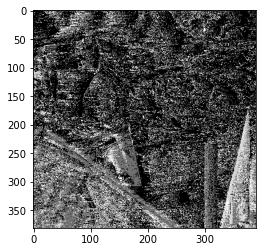

In [14]:
plt.imshow(depth_arr, cmap="gray")
plt.show()

## 4. Extend your implementation with the MRF’s smoothing priors using an eight neighborhood system (e.g. Ni,j = 􏰀(i−1,j −1),(i−1,j),(i−1,j +1),(i,j −1),(i,j +1),(i+1,j −1),(i+ 1,j),(i+1,j+1)􏰁. Feel free to choose either ICM or Gibbs sampling. Show me the smoothed results. You can use the Gaussian-kernel-looking prior probability equations discussed in class (M10 S8).

In [15]:
C = []
cluster_arr_smooth = np.array(cluster_arr)
old_cluster_arr = np.array(cluster_arr)
depth_arr_smooth = np.zeros(D.shape)

In [16]:
def get_p(x, y, k):
    level = [-1,0,1]
    prior_p = 1

    for m in level:
        for n in level:
            
            i = x+m
            j = y+n
            
    
            if i < 0 or j < 0 or i > old_cluster_arr.shape[0]-1 or j > old_cluster_arr.shape[1]-1 or old_cluster_arr[i,j] == k:
                prior_p *= 1
            else:
                prior_p *= (np.exp(-(5*5/(2*0.5*0.5))))

    return prior_p

In [17]:
for _ in range(30):
    for x in range(D.shape[0]):
        for y in range(D.shape[1]):

            current_cluster = cluster_arr[x,y]
            post = np.zeros(4)

            for k in range(4):
                a = 1/np.sqrt((2*np.pi*(SD_list[k]**2)))
                temp = depth_arr[x,y] - mean_list[k]
                b = np.exp(-(((temp)**2)/(2*(SD_list[k]**2))))
                
                pdf = a * b
                p = get_p(x,y,k)
                
                post[k] = pdf * p

            cluster_no = np.random.choice(np.arange(0, 4), p = post/np.sum(post))
            depth_arr_smooth[x,y] = mean_list[cluster_no]
            cluster_arr_smooth[x,y] = cluster_no

    C.append(depth_arr_smooth)
    old_cluster_arr = np.array(cluster_arr_smooth)

In [18]:
C = np.array(C)
smoothened_result = scipy.stats.mode(C[-10:])[0][0]

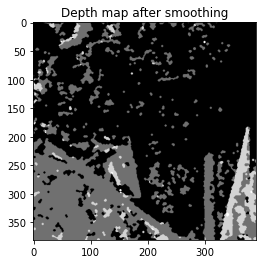

In [19]:
plt.title('Depth map after smoothing')
plt.imshow(smoothened_result, cmap="gray")
plt.show()